In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# MNE Librayry https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-pyimport mne
%%capture
!pip install mne
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import pandas as pd
import mne
import seaborn as sns
import torch

In [3]:
# On va chercher les données des participans pour des stats
path_dataset = "/content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/"
# /content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/participants.tsv
participants_data = pd.read_csv(path_dataset+"participants.tsv", sep='\t')


In [ ]:
# ========================================
# ==== Creation des jeux de donnees ===========
# ========================================

import mne
import torch
import numpy as np
import pandas as pd
# get all speech
# contenir des listes des 19 canaux pour les 88 patient
all_spectres = []

# les raw des patients
liste_de_rats = []

path_dataset = "/content/drive/MyDrive/ULaval AI/Dossier Martin - JF 2024/MLSP/Projet de session/DATA /Projet_Session-EEG-Alza/derivatives/"

files = os.listdir(path_dataset)
for i, fl in enumerate(files):
  # les fichier EEG .set avec mne
  raw = mne.io.read_raw_eeglab(path_dataset+fl+"/eeg/"+fl+"_task-eyesclosed_eeg.set",preload=True)

  # (n_channels x n_samples)
  data, times = raw.get_data(return_times=True)
  channels = raw.ch_names

  # Créer un DataFrame pandas pour liste_de_rats
  df = pd.DataFrame(data.T, columns=channels)  #(n_times, n_channels)
  df['time'] = times  # Ajout du temps
  liste_de_rats.append(df)
  # ========================================
  all_spectrogrames_canal = []

  # param pour les spectre et phase
  n_fft = 1024
  hop_length = 256
  window = torch.hamming_window(n_fft)
  # pour chaque canal - 19 -  dans le data
  for c in data:
    wav = torch.tensor(c, dtype=torch.float32)
    # spectrogramme d'amplitude
    # transformée de Fourier [Décalage entre les fenetres: hop_length=256]
    wav_stft_comp = torch.stft(wav, n_fft=1024, window=torch.hamming_window(1024), return_complex=True, hop_length=256)
    wav_stft = wav_stft_comp.abs()
    wav_stft = torch.log1p(wav_stft)
    wav_stft = (wav_stft - wav_stft.mean()) / wav_stft.std()
    all_spectrogrames_canal.append(wav_stft.squeeze())
  # on va prendre torch.cat
  all_spectrogrames_canal = torch.cat(all_spectrogrames_canal, dim=1).transpose(0, 1)

  print("all_spectrogrames_canal",all_spectrogrames_canal.shape)

  all_spectres.append(all_spectrogrames_canal)

  print("all_spectres",len(all_spectres))


In [ ]:
for i in range(len(all_spectres)):
  print(all_spectres[i].shape)

# taille minimale des spectrogrammes
target_length = min([spectrogram.shape[0] for spectrogram in all_spectres])

# On coupe toute
all_spectres = [spectrogram[:target_length, :] for spectrogram in all_spectres]

for i in range(len(all_spectres)):
  print(all_spectres[i].shape)

# torch.Size([11362, 513])

In [14]:
# ======= Rajout de la colonne Classe : 0-1 ou 0-1-2 =============
# 0 - 1 - 1
participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 1})
# 0 - 1 - 2
#participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 2})


<ipython-input-14-ff6007192bb0>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  participants_data['Class_norm_anorm']= participants_data['Group'].replace({'C': 0, 'A': 1, 'F': 1})


In [15]:
import torch
from torch.utils.data import Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels, n_times=128):
        self.segments = []
        self.labels = []

        # spectrogrammes en segments
        for spec, label in zip(spectrograms, labels):
            num_segments = spec.shape[0] // n_times
            spec = spec[:num_segments * n_times]
            spec_segments = spec.view(num_segments, n_times, -1).permute(0, 2, 1)  # (num_segments, n_freqs, n_times)
            self.segments.append(spec_segments)
            self.labels.extend([label] * num_segments)

        # segments et labels
        self.segments = torch.cat(self.segments, dim=0)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.segments[idx], self.labels[idx]

In [17]:
# Entrainement avec les spec
# information sur les data
print("all_spectres",len(all_spectres)) # 1 spectre par patient == all_spectres
# Shape de un spectre
print(" shape pour 1 patient 87",all_spectres[87].shape)
# ========== ================
# nos classe
labels = torch.tensor(participants_data['Class_norm_anorm'],dtype=torch.long)
print("labels",labels.shape)

"""
Fonction pour mettre tout le dataset sur le même nombre d'échantillons
"""
import torch
import pandas as pd
import numpy as np

# Data generator for on-the-fly padding
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, dataframes, max_rows, max_cols):
        self.dataframes = dataframes
        self.max_rows = max_rows
        self.max_cols = max_cols

    def __len__(self):
        return len(self.dataframes)

    def __getitem__(self, idx):
        # Pad the DataFrame for the given index
        df = self.dataframes[idx]
        array = df.values
        padded_array = np.pad(
            array,
            pad_width=((0, self.max_rows - array.shape[0]), (0, self.max_cols - array.shape[1])),
            mode='constant',
            constant_values=0
        )
        tensor = torch.tensor(padded_array, dtype=torch.float32)

        return tensor

all_spectres 88
 shape pour 1 patient 87 torch.Size([11362, 513])
labels torch.Size([88])


In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
# les DataLoaders
labels = torch.tensor(participants_data['Class_norm_anorm'],dtype=torch.long)
dataset = SpectrogramDataset(all_spectres, labels, n_times=128)

# ==== Transformation des datas =============================
X = np.array([all_spectres[i].numpy() for i in range(len(all_spectres))])
print("X", X.shape)
# [batch_size, channels, time_steps]
# 19 channels + 1 time column
X = X[:, :, :-1]
print("X [batch_size, channels, time_steps] : ", X.shape)
# (batch_size, channels, time_steps)
X = X.reshape(X.shape[0], 19, -1)
print("X sans time ", X.shape)

scaler = StandardScaler()
#   2D for scaling
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1))
print("X_scaled", X_scaled.shape)
#  back to 3D after scaling
dataset_scaled = X_scaled.reshape(X.shape[0], 19, -1)
print("dataset_scaled", dataset_scaled.shape)

# Split the data using NumPy arrays
X_train, X_test, y_train, y_test = train_test_split(dataset_scaled, labels, test_size=0.20, random_state=42)
print("=====================numpy========================")
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


X (88, 11362, 513)
X [batch_size, channels, time_steps] :  (88, 11362, 512)
X sans time  (88, 19, 306176)
X_scaled (88, 5817344)
dataset_scaled (88, 19, 306176)
=====================numpy========================
X_train (70, 19, 306176)
y_train torch.Size([70])
X_test (18, 19, 306176)
y_test torch.Size([18])


In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Paramètres
n_times = 128
stride = 64   # Décalage entre segments

# Fonction pour segmenter les données
def segment_data(data, n_times, stride):
    n_patients, n_channels, n_points = data.shape
    segments = []
    for patient in range(n_patients):
        for start in range(0, n_points - n_times + 1, stride):
            segment = data[patient, :, start:start + n_times]
            segments.append(segment)
    return np.array(segments)

# dataset train segment
dataset_segments_train = segment_data(X_train, n_times=n_times, stride=stride)
print("Format des segments train :", dataset_segments_train.shape)

y_labels_train = np.array(y_train)
# Classes
labels_train = np.repeat(y_labels_train, dataset_segments_train.shape[0] // len(y_labels_train))
print("Format des étiquettes train :", labels_train.shape)

# dataset test segment
dataset_segments_test = segment_data(X_test, n_times=n_times, stride=stride)
print("Format des segments test :", dataset_segments_test.shape)

y_labels_test = np.array(y_test)
# Classes
labels_test = np.repeat(y_labels_test, dataset_segments_test.shape[0] // len(y_labels_test))
print("Format des étiquettes test :", labels_test.shape)

Format des segments train : (334810, 19, 128)
Format des étiquettes train : (334810,)
Format des segments test : (86094, 19, 128)
Format des étiquettes test : (86094,)


In [24]:
# upsampling de classes
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
# compte de classes
class_counts = np.bincount(labels_train)
class_counts_ = np.bincount(labels_test)
# compte les occurences de chaque classe
class_weights = 1 / class_counts
class_weights_ = 1 / class_counts_

# calcul des poids
sample_weights = class_weights[labels_train]
sample_weights_ = class_weights_[labels_test]

# Creation des samples
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
sampler_ = WeightedRandomSampler(weights=sample_weights_, num_samples=len(sample_weights_), replacement=True)

# Datalaoder test et train
# données en tenseurs PyTorch
# DataLoader train
batch_size = 16
X = torch.tensor(dataset_segments_train, dtype=torch.float32)
y = torch.tensor(labels_train, dtype=torch.long)
dataloader_train = DataLoader(TensorDataset(X, y), batch_size=batch_size, sampler=sampler, pin_memory=True)

print("Taille du DataLoader train :", len(dataloader_train))

# DataLoader test
# données en tenseurs PyTorch
X = torch.tensor(dataset_segments_test, dtype=torch.float32)
y = torch.tensor(labels_test, dtype=torch.long)

dataset = TensorDataset(X, y)
dataloader_test = DataLoader(TensorDataset(X, y), batch_size=batch_size, sampler=sampler_, pin_memory=True)

print("Taille du DataLoader test :", len(dataloader_test))

Taille du DataLoader train : 20926
Taille du DataLoader test : 5381


In [25]:
# Code test pour voir les dataloader
# Data train
print('datalodataloader_train ')
for i, l in dataloader_train:
  print('I batch dimensions:', i.size())
  print('L label dimensions:', l.size())
  print(l[:16])
  break
print(len(dataloader_train))

# Data test
print('datalodtest: ')
for i, l in dataloader_test:
  print('I batch dimensions:', i.size())
  print('L label dimensions:', l.size())
  print(l[:16])
  break

print(len(dataloader_test))

datalodataloader_train 
I batch dimensions: torch.Size([16, 19, 128])
L label dimensions: torch.Size([16])
tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0])
20926
datalodtest: 
I batch dimensions: torch.Size([16, 19, 128])
L label dimensions: torch.Size([16])
tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0])
5381


In [27]:
%%capture
!pip install braindecode

In [28]:
# ======================================
# https://huggingface.co/guido151/EEGNetv4
# ======================================
from braindecode.models import EEGNetv4
from huggingface_hub import hf_hub_download
from skorch import NeuralNet
import torch.nn as nn
import torch as th
import torch
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
# fichiers pour initialiser et charger le modele pretrain
path_params = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/params.pt',)
path_optimizer = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/optimizer.pt',)
path_history = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/history.json',)
path_criterion = hf_hub_download(repo_id='guido151/EEGNetv4',filename='EEGNetv4_Lee2019_ERP/criterion.pt',)

model = EEGNetv4(n_chans=19,
                 n_outputs=2,
                 n_times=128,)

net = NeuralNet(model, criterion=nn.CrossEntropyLoss(weight=th.tensor([1, 1])),)
net.initialize()
net.load_params(path_params,
                path_optimizer,
                path_criterion,
                path_history,)

def get_fid_model(model: EEGNetv4) -> nn.Module:
    fid_model = deepcopy(model)
    for i in range(len(fid_model)):
        if i >= 14:
            fid_model[i] = Identity()
    fid_model.eval()
    for param in fid_model.parameters():
        param.requires_grad = False
    return fid_model

def get_is_model(model: EEGNetv4) -> nn.Module:
    is_model = deepcopy(model)
    is_model.eval()
    for param in is_model.parameters():
        param.requires_grad = False
    return is_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


params.pt:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

history.json:   0%|          | 0.00/35.5M [00:00<?, ?B/s]

criterion.pt:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/skorch/net.py:2626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f_name, map_location=map_location)


In [42]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialisation du modèle
model = EEGNetv4(n_chans=19, n_outputs=2, n_times=128)
model.to(device)
# Initialisation avec le param beta
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Chargement des poids uniquement
model.load_state_dict(torch.load(path_params, map_location=torch.device('cpu')))
criterion.weight = criterion.weight.to(device)

Using device: cuda


<ipython-input-42-15679d3094e6>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_params, map_location=torch.device('cpu')))


In [44]:
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

#  mode entraînement
model.train()

# Paramètres
n_epochs = 50

train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Boucle d'entraînement
    for X_batch, y_batch in dataloader_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Calcul des métriques
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)

        all_labels.extend(y_batch.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    # Calcul des métriques pour l'époque
    train_loss = running_loss / len(dataloader_train)
    train_accuracy = 100.0 * correct / total
    train_precision = precision_score(all_labels, all_predictions, average='weighted')
    train_recall = recall_score(all_labels, all_predictions, average='weighted')
    train_f1 = f1_score(all_labels, all_predictions, average='weighted')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    # Temps écoulé pour l'époque
    end_time = time.time()
    epoch_time = end_time - start_time

    # Affichage des résultats
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"  Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-score: {train_f1:.2f}")
    print(f"  Time: {epoch_time:.2f} seconds")

    # Matrice de confusion
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix (Epoch {epoch+1}):\n{conf_matrix}")


Epoch 1/50
  Loss: 0.6900, Accuracy: 52.49%
  Precision: 0.52, Recall: 0.52, F1-score: 0.52
  Time: 102.34 seconds
Confusion Matrix (Epoch 1):
[[86221 81023]
 [78049 89517]]
Epoch 2/50
  Loss: 0.6809, Accuracy: 54.63%
  Precision: 0.55, Recall: 0.55, F1-score: 0.55
  Time: 98.07 seconds
Confusion Matrix (Epoch 2):
[[88589 79035]
 [72858 94328]]
Epoch 3/50
  Loss: 0.6751, Accuracy: 55.52%
  Precision: 0.56, Recall: 0.56, F1-score: 0.55
  Time: 98.53 seconds
Confusion Matrix (Epoch 3):
[[88584 78595]
 [70326 97305]]
Epoch 4/50
  Loss: 0.6712, Accuracy: 56.11%
  Precision: 0.56, Recall: 0.56, F1-score: 0.56
  Time: 97.85 seconds
Confusion Matrix (Epoch 4):
[[90629 76682]
 [70258 97241]]
Epoch 5/50
  Loss: 0.6698, Accuracy: 56.15%
  Precision: 0.56, Recall: 0.56, F1-score: 0.56
  Time: 97.38 seconds
Confusion Matrix (Epoch 5):
[[90363 77049]
 [69750 97648]]
Epoch 6/50
  Loss: 0.6680, Accuracy: 56.43%
  Precision: 0.56, Recall: 0.56, F1-score: 0.56
  Time: 95.70 seconds
Confusion Matrix (Ep

In [45]:
# Evaluation en train et test
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

model.eval()
y_true_train = []
y_pred_train = []
with torch.no_grad():
    for inputs, labels in dataloader_train:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true_train, y_pred_train)
precision = precision_score(y_true_train, y_pred_train)
recall = recall_score(y_true_train, y_pred_train)
f1 = f1_score(y_true_train, y_pred_train)

print("Metrique pour Train vnet4")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Afficher un rapport détaillé
print("\nClassification Report (Train):")
print(classification_report(y_true_train, y_pred_train, digits=2))

model.eval()
y_true_test = []
y_pred_test = []
with torch.no_grad():
    for inputs, labels in dataloader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true_test, y_pred_test)
precision = precision_score(y_true_test, y_pred_test)
recall = recall_score(y_true_test, y_pred_test)
f1 = f1_score(y_true_test, y_pred_test)
print("=="*100)
print("Metrique pour Test vnet4")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

print("\nClassification Report (Test):")
print(classification_report(y_true_test, y_pred_test, digits=2))

Metrique pour Train vnet4
Accuracy: 0.59
Precision: 0.61
Recall: 0.53
F1-Score: 0.57

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.58      0.66      0.62    167393
           1       0.61      0.53      0.57    167417

    accuracy                           0.59    334810
   macro avg       0.60      0.59      0.59    334810
weighted avg       0.60      0.59      0.59    334810

Metrique pour Test vnet4
Accuracy: 0.48
Precision: 0.48
Recall: 0.48
F1-Score: 0.48

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.48      0.48      0.48     43027
           1       0.48      0.48      0.48     43067

    accuracy                           0.48     86094
   macro avg       0.48      0.48      0.48     86094
weighted avg       0.48      0.48      0.48     86094



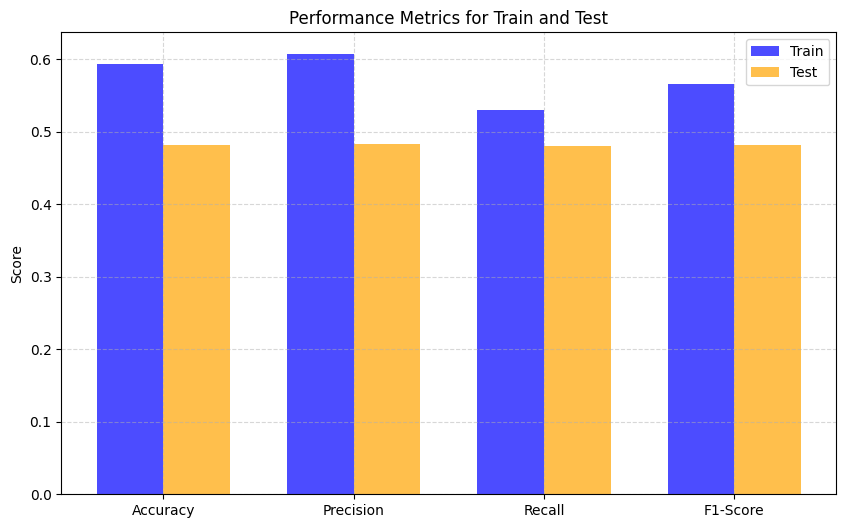

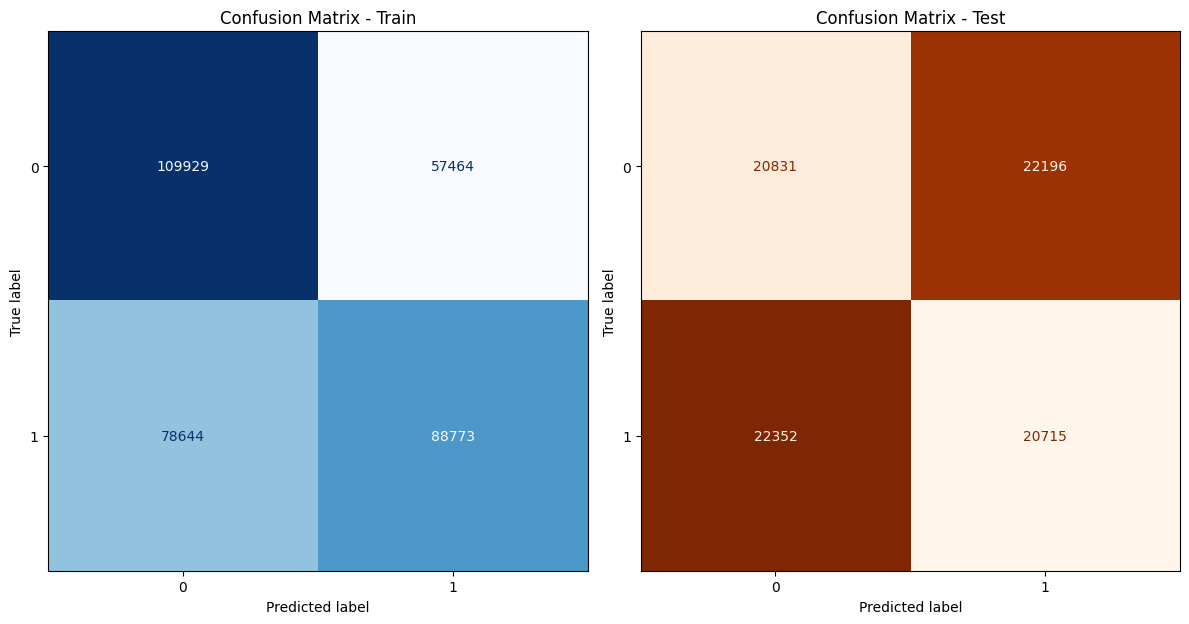

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# métriques pour l'entraînement
train_metrics = {
    "Accuracy": accuracy_score(y_true_train, y_pred_train),
    "Precision": precision_score(y_true_train, y_pred_train),
    "Recall": recall_score(y_true_train, y_pred_train),
    "F1-Score": f1_score(y_true_train, y_pred_train),
}

# métriques pour le test
test_metrics = {
    "Accuracy": accuracy_score(y_true_test, y_pred_test),
    "Precision": precision_score(y_true_test, y_pred_test),
    "Recall": recall_score(y_true_test, y_pred_test),
    "F1-Score": f1_score(y_true_test, y_pred_test),
}

# métriques sous forme de barres
labels = list(train_metrics.keys())
train_values = list(train_metrics.values())
test_values = list(test_metrics.values())

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_values, width, label='Train', color='blue', alpha=0.7)
plt.bar(x + width/2, test_values, width, label='Test', color='orange', alpha=0.7)
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Performance Metrics for Train and Test")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Confusion Matrix - Train")

ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(ax=axes[1], cmap="Oranges", colorbar=False)
axes[1].set_title("Confusion Matrix - Test")

plt.tight_layout()
plt.show()